In [5]:
# import
import keras
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.utils import np_utils, plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn import model_selection
from sklearn.manifold import TSNE
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
import h5py as h5py

In [2]:
BINARY = False
timestep = 1
epochs = 10
en_corpus_file = "corpus-en.txt"
ewo_corpus_file = "corpus-ewo.txt"
best_model_file = "best-model-conll.hdfs"
max_nb_of_phrases =  -1
duplication = 1
max_depth = 0
is_only_vocab = True
shuffle = is_only_vocab

tsne = TSNE(n_components=2)

NameError: name 'TSNE' is not defined

In [211]:
def getTag(aString):
    tag = "O"
    if BINARY:
        if aString != "O":
            return "NE"
    else:
        tag = aString
    return tag
     

In [212]:
def load_corpus(file, max_nb_of_phrases):
    nb_of_phrases = 0
    dataset = {"word": [], "ne-tag": []}
    with open(file) as f:
        prev_line = None
        for cpt, line in enumerate(f):
            if cpt == 0:
                continue
            if nb_of_phrases == max_nb_of_phrases:
                break;

            l = line.strip()
            if len(l) == 0 and len(prev_line) != 0:
                nb_of_phrases += 1
                dataset["word"].append(line)
                dataset["ne-tag"].append(None)
            else:
                l = l.split("\t")
                dataset["word"].append(l[0])
                dataset["ne-tag"].append(ne_type(l[1]))
            prev_line = line.strip()
        
    return pd.DataFrame(dataset), nb_of_phrases+1

In [213]:
def corpus_fingerprint(aDataframe, nb_of_biphrases):
    # create distributionnal signature
    fingerprints = {}
    current_bi_phrase_index = 0
    nb_word_in_corpus = aDataframe[aDataframe.word != "\n"].word.size
    words_in_current_phrase = []
    for index, row in aDataframe.iterrows():
        if current_bi_phrase_index > nb_of_biphrases:
            break
            
        word = row['word']
        
        if word != "\n":
            words_in_current_phrase.append(word)
            if word not in fingerprints:
                fingerprints[word] = np.zeros(nb_of_biphrases, dtype=np.float32)
            fingerprints[word][current_bi_phrase_index] += 1
        else:
            nb_word_in_current_phrase = len(words_in_current_phrase)
#             for w in words_in_current_phrase:
#                 fingerprints[w][current_bi_phrase_index] = nb_word_in_corpus / fingerprints[w][current_bi_phrase_index]                
            current_bi_phrase_index += 1
            words_in_current_phrase = []
    for word in fingerprints:
        for i in range(nb_of_biphrases):
            if fingerprints[word][i] != 0:
                fingerprints[word][i] = nb_word_in_corpus / fingerprints[word][i]
#         fingerprints[word][nb_of_biphrases] = nb_word_in_corpus / aDataframe[aDataframe.word == word].word.size
        
    return pd.DataFrame(fingerprints)

In [214]:
def corpus2trainingdata(aDataframe, fingerprintsDataFrame):
    X = np.zeros((aDataframe.shape[0], fingerprintsDataFrame.shape[0]), dtype=np.int8)
    y = np.zeros(aDataframe.shape[0], dtype=np.int8)
    i = 0
    for row in aDataframe.iterrows():
        X[i] = fingerprintsDataFrame[row[1]['word']].values
        y[i] = tag2int[getTag(row[1]['ne-tag'])]
        i += 1
    return X, y

In [215]:
def train_test_split(X, y, test_size = 0.33):
    total = X.shape[0]
    train_length = round(total * (1 - test_size)) 
    return X[:train_length], X[train_length:], y[:train_length], y[train_length:]

In [216]:
  
def ne_type(aType):
    aType = aType.lower()
    if 'per' in aType:
        t =  'NE' if BINARY else 'PER' 
    elif 'loc' in aType:
        t =  'NE' if BINARY else 'LOC'
    elif 'org' in aType:
        t =  'NE' if BINARY else 'ORG'
    elif 'hour' in aType:
        t =  'NE' if BINARY else 'MISC'
    elif aType != 'o' and len(aType) > 0 :
        t =  'NE' if BINARY else 'MISC'
    else:
        t = 'O'
    return t

In [217]:
def compute_performance(y_true, y_pred, words=None, BINARY=False):
    if BINARY:
        p = precision_score(y_true, y_pred, pos_label=tag2int['NE'])
        r = recall_score(y_true, y_pred, pos_label=tag2int['NE'])
        f1 = f1_score(y_true, y_pred, pos_label=tag2int['NE'])
        acc = accuracy_score(y_true, y_pred)
    else:
        p = precision_score(y_pred, y_true, average='macro')
        r = recall_score(y_pred, y_true, average='macro')
        f1 = f1_score(y_pred, y_true, average='macro')
        acc = accuracy_score(y_pred, y_true)
    if words is None:
        model_output_vs = pd.DataFrame({'y_true': [int2tag[i] for i in y_true], 'y_pred': [int2tag[i] for i in y_pred]})
    else:
        model_output_vs = pd.DataFrame({'word': words, 'y_true': [int2tag[i] for i in y_true], 'y_pred': [int2tag[i] for i in y_pred]})

    return p, r, f1, acc, model_output_vs

In [218]:
def P_R_F1(y_pred, y_true, neg_class):
    same = y_pred[y_true==y_pred]
    tp = same[same != neg_class].size
    nb_of_pos_exple = y_true[y_true != neg_class].size
    nb_of_pos_pred = y_pred[y_pred != neg_class].size
    p = r = f1 = 0
    try:
        p = np.round(tp*100/nb_of_pos_pred, 2)
    except ZeroDivisionError:
        print("number of correct positive predictions is 0")
        
    try:
        r = np.round(tp*100/nb_of_pos_exple, 2)
    except ZeroDivisionError:
        print("number of position exple is 0")
        
    try:
        f1 = np.round(2*r*p/(r+p), 2)
    except ZeroDivisionError:
        print("Recall and precision are 0")

    return p, r, f1

In [219]:
def is_mergeable(aListOfConsecutiveTokens, corpus, fingerprints):
    n = len(aListOfConsecutiveTokens)
    if n <= 1:
        return False
    if n == 2:
        w1, w2 = aListOfConsecutiveTokens[0], aListOfConsecutiveTokens[1]
        rep1, rep2 = fingerprints[aListOfConsecutiveTokens[0]], fingerprints[aListOfConsecutiveTokens[1]]
        tag1, tag2 = corpus[corpus.word==w1].iloc[0]['ne-tag'], corpus[corpus.word==w2].iloc[0]['ne-tag']
        if (tag1 == tag2) and (tag1 == "O"): # O + O => False
            return False
        if (tag1 != tag2) and (tag1 != "O") and (tag2 != "O"): # X + Y => False
            return False
        return rep1.equals(rep2)
    else:
        half = int(n / 2)
        return is_mergeable(aListOfConsecutiveTokens[0:half+1], corpus, fingerprints) and is_mergeable(aListOfConsecutiveTokens[half:n], corpus, fingerprints)

In [220]:
def merge(depth, corpus, fingerprint):
    wordDf = corpus[corpus.word != "\n"].word
    nbOfWord = wordDf.shape[0]
    text = list(wordDf)
    X2, target2, tokens = [], [], []
    level, newToken = 1, True
    while level <= depth and newToken:
        i, newToken = 0, False
        limit = nbOfWord - level
        while i < limit:
            if is_mergeable(text[i:i+level+1], corpus, fingerprint):
                tokens.append(" ".join(text[i:i+level+1]))
                newToken = True
            i += 1
        print("level ", level, ":", set(tokens))
        level += 1
    
    X2, target2 = np.array(X2), np.array(target2)
    
    return X2, target2, set(tokens)

In [221]:
def shuffle(X, y):
    indices = [i for i in  range(X.shape[0])]
    np.random.shuffle(indices)
    return X[indices], y[indices]

In [222]:
def visualize(corpus, fingerprints, fname = None ):    
    columns = fingerprints.columns
    targets = []
    X = np.zeros((fingerprints.shape[1], fingerprints.shape[0]))
    for i, c in enumerate(columns):
        X[i] = fingerprints[c].values
        targets.append(corpus[corpus.word == c].iloc[0]['ne-tag'])
    ids = np.array([tag2int[t] for t in targets])
    X_2d = tsne.fit_transform(X)
    
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    colors = 'r', 'g', 'b', 'c', 'yellow'
    for label, c in zip(np.unique(targets), colors):
        plt.scatter(X_2d[ids == tag2int[label], 0], X_2d[ids == tag2int[label], 1], c=c, label=label)
    plt.legend()
    plt.title("Frequency")
    
    X[X > 0] = 1
    X_2d = tsne.fit_transform(X)
    plt.subplot(122)
    colors = 'r', 'g', 'b', 'c', 'yellow'
    for label, c in zip(np.unique(targets), colors):
        plt.scatter(X_2d[ids == tag2int[label], 0], X_2d[ids == tag2int[label], 1], c=c, label=label)
    plt.legend()
    plt.title("One Hot Encoding")
    
    
    if fname is not None:
        plt.savefig(fname)
    
    plt.show()

In [223]:
en_corpus, en_nb_of_phrases = load_corpus(en_corpus_file, max_nb_of_phrases)

In [224]:
tagSet = en_corpus["ne-tag"].dropna().unique()
if BINARY:
    tagSet = ['NE', 'O']
tag2int = {j: i for i, j in enumerate(tagSet)}
int2tag = {i: j for i, j in enumerate(tagSet)}
print(tag2int)

{'O': 0, 'MISC': 1, 'PER': 2, 'LOC': 3, 'ORG': 4}


In [225]:
en_nb_of_phrases

210

In [226]:
en_corpus.describe()

,ne-tag,word
count,4753,4962
unique,5,913
top,O,","
freq,4362,343


In [227]:
en_corpus.head(10)

,ne-tag,word
0,O,The
1,O,Promise
2,O,of
3,O,the
4,MISC,Holy
5,MISC,Spirit
6,None,\n
7,O,In
8,O,the
9,O,first


In [228]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(en_corpus[en_corpus['ne-tag']==tag].shape[0] * 100 / en_corpus[en_corpus['ne-tag']!='\n'].shape[0], 2)))

O % = 87.91 %
MISC % = 2.12 %
PER % = 4.94 %
LOC % = 0.81 %
ORG % = 0.02 %


In [229]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(en_corpus[en_corpus['ne-tag']==tag].word.unique().shape[0] * 100 / en_corpus[en_corpus['ne-tag']!='\n'].word.unique().shape[0], 2)))

O % = 89.27 %
MISC % = 1.86 %
PER % = 8.87 %
LOC % = 1.97 %
ORG % = 0.11 %


In [230]:
en_corpus[en_corpus.word == "\n"].shape

(209, 2)

In [231]:
print("Nb of bi-phrases", en_nb_of_phrases)
en_fingerprints = corpus_fingerprint(en_corpus, en_nb_of_phrases)

Nb of bi-phrases 210


In [232]:
en_fingerprints.head(10)

,!,"""",','And,'Let,'May,'The,'Why,(Now,(the,...,word,words,would,write,writing,written,wrote,years,you,your
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,4753.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4753.000000,0.0
5,0.0,4753.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4753.000000,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
7,0.0,2376.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4753.000000,0.0
8,0.0,4753.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4753.000000,0.0
9,0.0,4753.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1584.333374,0.0


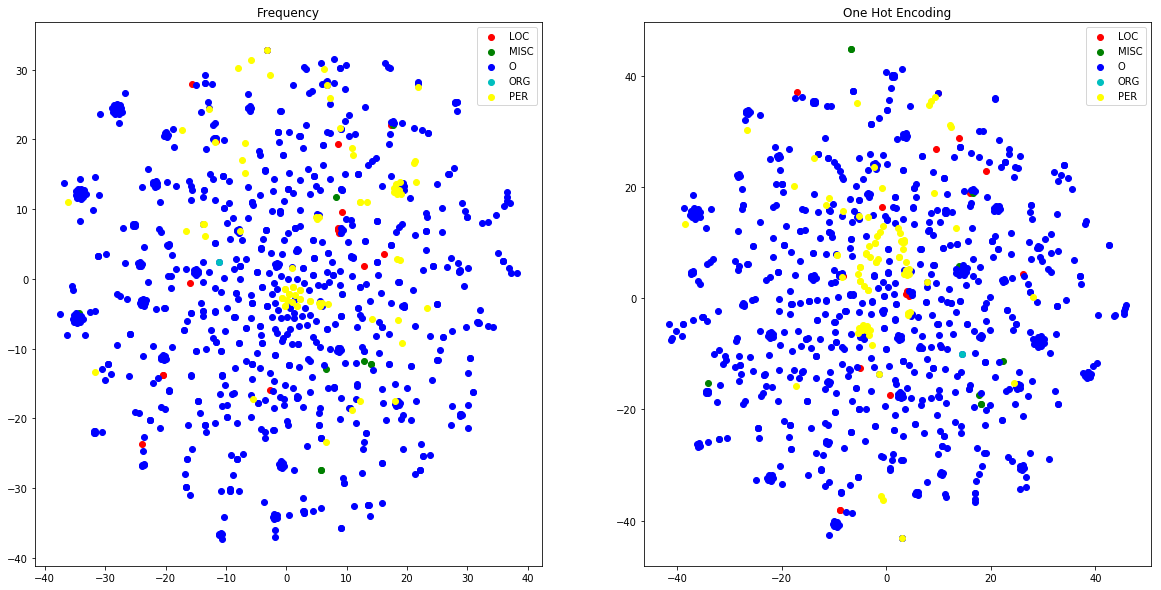

In [233]:
visualize(en_corpus, en_fingerprints, "en-corpus.png")

In [234]:
en_fingerprints['you'].values.shape

(210,)

In [235]:
en_corpus[en_corpus.word != "\n"].shape

(4753, 2)

In [236]:
X2, target2, tokens = merge(max_depth, en_corpus, en_fingerprints)

In [237]:
if is_only_vocab:
    text = list(en_corpus[en_corpus.word != "\n"].word.unique())
else:
    text = list(en_corpus[en_corpus.word != "\n"].word)
en_vocab = pd.DataFrame({'text': text + list(tokens)})
en_vocab.describe()

,text
count,912
unique,912
top,upper
freq,1


In [238]:
if is_only_vocab:
    X = np.zeros((en_vocab.shape[0] * duplication, en_nb_of_phrases))
    target = np.zeros((en_vocab.shape[0] * duplication))
    p=0
    for i, row in en_vocab.iterrows():
        c = row.text
        for j in range(duplication):
            X[p] = en_fingerprints[c.split(" ")[0]]
            target[p] = tag2int[getTag(en_corpus[en_corpus.word == c.split(" ")[-1:][0]]['ne-tag'].iloc[0])]
            p+=1
    X, target = shuffle(X, target)
    print(X.shape, en_fingerprints.shape, target.shape)

(912, 210) (210, 912) (912,)


In [239]:
en_vocab[-20:]

,text
892,Eliud
893,Eleazar
894,Matthan
895,husband
896,fourteen
897,unwilling
898,shame
899,resolved
900,divorce
901,quietly


In [240]:
if not is_only_vocab:
    X, target = corpus2trainingdata(en_corpus[en_corpus.word != "\n"], en_fingerprints)

In [241]:
print(X.shape, target.shape)
if len(X.shape) == len(X2.shape):
    X = np.concatenate((X, X2))
    target = np.concatenate((target, target2))
    if shuffle:
        X, target = shuffle(X, target)
print(X.shape, target.shape)

(912, 210) (912,)
(912, 210) (912,)


In [242]:
y = target.copy()
y[0:100]
if not BINARY:
    y = np_utils.to_categorical(y, len(tagSet))
y.shape

(912, 5)

In [243]:
X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.33)
X_train = X_train.reshape(X_train.shape[0], timestep, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], timestep, X_val.shape[1])
print("X_train.shape =", X_train.shape)
print("y_train.shape =", y_train.shape)
print("X_val.shape =", X_val.shape)
print("y_val.shape =", y_val.shape)

tTarget = np.array([np.argmax(yy) for yy in y_train])
vTarget = np.array([np.argmax(yy) for yy in y_val])

for tag in tagSet:
    print("{0} % in training data = {1} %".format(tag, np.round(tTarget[tTarget==tag2int[tag]].size * 100 / tTarget.shape[0], 2)))
    print("{0} % in validation data = {1} %".format(tag, np.round(vTarget[vTarget==tag2int[tag]].size * 100 / vTarget.shape[0], 2)))

X_train.shape = (611, 1, 210)
y_train.shape = (611, 5)
X_val.shape = (301, 1, 210)
y_val.shape = (301, 5)
O % in training data = 89.03 %
O % in validation data = 87.04 %
MISC % in training data = 0.82 %
MISC % in validation data = 1.99 %
PER % in training data = 8.51 %
PER % in validation data = 8.31 %
LOC % in training data = 1.64 %
LOC % in validation data = 2.33 %
ORG % in training data = 0.0 %
ORG % in validation data = 0.33 %


In [244]:
def create_model(input_dim, output_dim):
    model = Sequential()
    model.add(SimpleRNN(640, input_shape=(None, input_dim), activation='sigmoid'))
    model.add(Dense(160, activation='sigmoid'))
    if BINARY:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['binary_accuracy'])
    else:
        model.add(Dense(output_dim, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])
    return model

In [245]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=epochs):
    early_stop = EarlyStopping(patience=2, verbose=2) # stop learning if the error is the same between two consecutive epochs
    best_model_cp = ModelCheckpoint(best_model_file, save_best_only=True, verbose=2) # saved best model
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=0, shuffle=shuffle, callbacks=[best_model_cp, early_stop])
    best_model = keras.models.load_model(best_model_file) #loading the best model
    return best_model

In [246]:
def predict(model, X, y, binary=BINARY):
    if BINARY:
        y_pred = np.round(model.predict(X))
        y_true = y
    else:
        predictions = model.predict(X)
        y_pred = np.array([np.argmax(p) for p in predictions])
        y_true = np.array([np.argmax(t) for t in y ])
    return y_true, y_pred

In [247]:
def model_performance(y_true, y_pred):
    return P_R_F1(y_pred, y_true, tag2int['O']) #precision, recall, f1-score

In [248]:
def model_performace_by_tag(y_true, y_pred, tag):
    p, r, f1 = 0, 0, 0
    
    eq = y_pred[y_pred==y_true]
    correctly_pred = eq[eq==tag].size
    try:
        p = np.round(100 * correctly_pred / y_pred[y_pred==tag].size, 2)
    except ZeroDivisionError:
        pass
    
    try:
        r = np.round(100 * correctly_pred / y_true[y_true==tag].size, 2)
    except ZeroDivisionError:
        pass
    
    try:
        f1 = np.round(2 * r * p / (r + p), 2)
    except ZeroDivisionError:
        pass
    
    return p, r, f1

In [249]:
ewo_corpus, ewo_nb_of_phrases = load_corpus(ewo_corpus_file, max_nb_of_phrases)

In [250]:
ewo_nb_of_phrases

210

In [251]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(ewo_corpus[ewo_corpus['ne-tag']==tag].shape[0] * 100 / ewo_corpus[ewo_corpus['ne-tag']!='\n'].shape[0], 2)))

O % = 86.37 %
MISC % = 2.18 %
PER % = 5.76 %
LOC % = 0.89 %
ORG % = 0.05 %


In [252]:
for tag in tagSet:
    print("{0} % = {1} %".format(tag, np.round(ewo_corpus[ewo_corpus['ne-tag']==tag].word.unique().shape[0] * 100 / ewo_corpus[ewo_corpus['ne-tag']!='\n'].word.unique().shape[0], 2)))

O % = 90.0 %
MISC % = 1.17 %
PER % = 8.25 %
LOC % = 1.84 %
ORG % = 0.19 %


In [253]:
ewo_corpus.describe()

,ne-tag,word
count,4185,4394
unique,5,1030
top,O,","
freq,3795,413


In [254]:
ewo_corpus.head()

,ne-tag,word
0,MISC,Mfufub
1,MISC,Nsisim
2,O,ayi
3,O,sò
4,None,\n


In [255]:
ewo_fingerprints = corpus_fingerprint(ewo_corpus, en_nb_of_phrases)

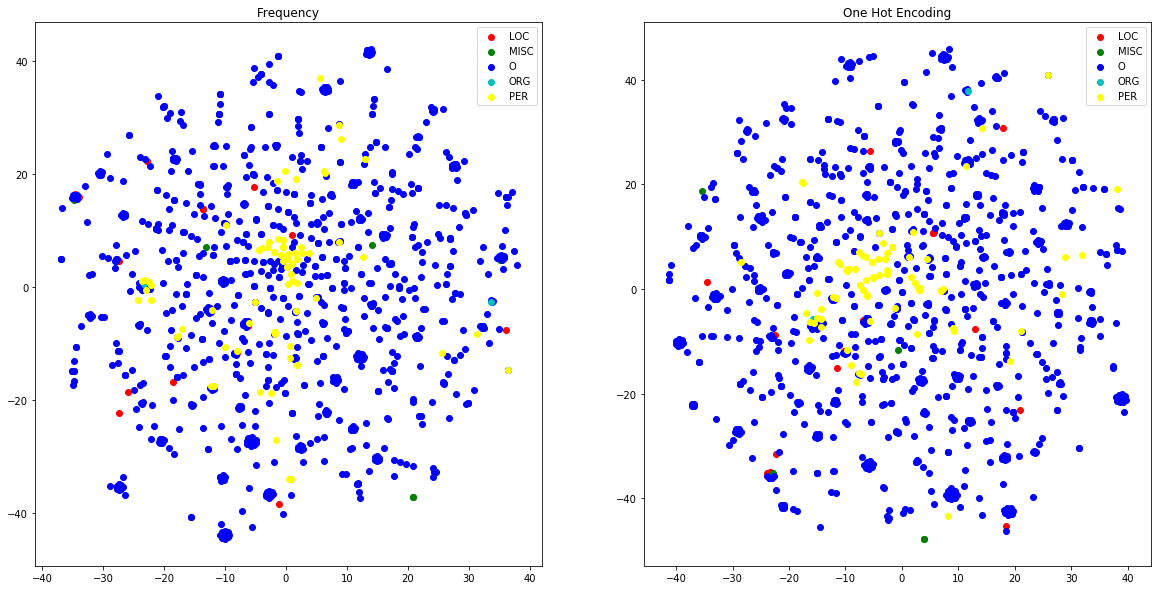

In [256]:
visualize(ewo_corpus, ewo_fingerprints, "ewo-corpus.png")

In [257]:
X2, target2, tokens = merge(max_depth, ewo_corpus, ewo_fingerprints)

In [258]:
if is_only_vocab:
    text = list(ewo_corpus[ewo_corpus.word != "\n"].word.unique())
else:
    text = list(ewo_corpus[ewo_corpus.word != "\n"].word)
ewo_vocab = pd.DataFrame({"text":text + list(tokens)})

In [259]:
if is_only_vocab:
    X_ewo = np.zeros((ewo_vocab.shape[0] * duplication, en_nb_of_phrases))
    ewo_target = np.zeros((ewo_vocab.shape[0] * duplication))
    p=0
    for i, row in ewo_vocab.iterrows():
        c = row.text
        for j in range(duplication):
            X_ewo[p] = ewo_fingerprints[c.split(" ")[0]]
            ewo_target[p] = tag2int[getTag(ewo_corpus[ewo_corpus.word == c.split(" ")[-1:][0]]['ne-tag'].iloc[0])]
            p+=1
    X_ewo, ewo_target = shuffle(X_ewo, ewo_target)

In [260]:
ewo_vocab[-20:]

,text
1009,nlo
1010,obë
1011,mbara
1012,yabyali
1013,dzili
1014,yasò
1015,oyolëge
1016,kode
1017,dili
1018,atoban


In [261]:
if not is_only_vocab:
    X_ewo, ewo_target = corpus2trainingdata(ewo_corpus[ewo_corpus.word != "\n"], ewo_fingerprints)

In [262]:
print(X_ewo.shape, ewo_target.shape)
if len(X_ewo.shape) == len(X2.shape):
    X_ewo = np.concatenate((X_ewo, X2))
    ewo_target = np.concatenate((ewo_target, target2))
    if shuffle:
        X_ewo, ewo_target = shuffle(X_ewo, ewo_target)
print(X_ewo.shape, ewo_target.shape)

(1029, 210) (1029,)
(1029, 210) (1029,)


In [263]:
y_ewo = ewo_target.copy()
print(y_ewo.shape, len(ewo_vocab))

(1029,) 1029


In [264]:
X_ewo.shape

(1029, 210)

In [265]:
y_ewo = ewo_target.copy()
y_ewo[:20]
if not BINARY:
    y_ewo = np_utils.to_categorical(y_ewo)

In [266]:
X_ewo = X_ewo.reshape((X_ewo.shape[0], timestep, en_nb_of_phrases))

In [267]:
def algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, epochs=epochs, model=None):
    test_precision, train_precision, ewo_precision = [], [], []
    test_recall, train_recall, ewo_recall = [], [], []
    test_fscore, train_fscore, ewo_fscore = [], [], []
    
    test_result_by_tag = {}
    train_result_by_tag = {}
    ewo_result_by_tag = {}
    for t in tagSet:
        f1_key = "F1-"+t
        p_key = "P-"+t
        r_key = "R-"+t
        train_result_by_tag[f1_key], train_result_by_tag[p_key], train_result_by_tag[r_key] = [], [], []
        test_result_by_tag[f1_key], test_result_by_tag[p_key], test_result_by_tag[r_key] = [], [], []
        ewo_result_by_tag[f1_key], ewo_result_by_tag[p_key], ewo_result_by_tag[r_key] = [], [], []

    m = train_model(model, X_train, y_train, X_val, y_val, epochs=epochs)
        
    y_true, y_pred = predict(m, X_train, y_train)
    p_train, r_train, f1_train = model_performance(y_true, y_pred)
        
    y_true_val, y_pred_val = predict(m, X_val, y_val)
    p_val, r_val, f1_val = model_performance(y_true_val, y_pred_val)
        
    y_true_ewo, y_pred_ewo = predict(m, X_ewo, y_ewo) 
    p_ewo, r_ewo, f1_ewo = model_performance(y_true_ewo, y_pred_ewo)
        
    for t in range(len(int2tag)):
        f1_key = "F1-" + int2tag[t]
        p_key = "P-" + int2tag[t]
        r_key = "R-" + int2tag[t]
            
        p, r, f1 = model_performace_by_tag(y_true, y_pred, t)
        train_result_by_tag[p_key].append(p)
        train_result_by_tag[r_key].append(r)
        train_result_by_tag[f1_key].append(f1)
            
        p, r, f1 = model_performace_by_tag(y_true_val, y_pred_val, t)
        test_result_by_tag[p_key].append(p)
        test_result_by_tag[r_key].append(r)
        test_result_by_tag[f1_key].append(f1)
            
        p, r, f1 = model_performace_by_tag(y_true_ewo, y_pred_ewo, t)
        ewo_result_by_tag[p_key].append(p)
        ewo_result_by_tag[r_key].append(r)
        ewo_result_by_tag[f1_key].append(f1)
                
    test_precision.append(p_val)
    train_precision.append(p_train)
    ewo_precision.append(p_ewo)
        
    test_recall.append(r_val)
    train_recall.append(r_train)
    ewo_recall.append(r_ewo)
        
    test_fscore.append(f1_val)
    train_fscore.append(f1_train)
    ewo_fscore.append(f1_ewo)
    return pd.DataFrame({
        'P_test': test_precision, 
        'P_train': train_precision, 
        'P_ewo': ewo_precision, 'R_test': test_recall, 'R_train': train_recall, 
        'R_ewo': ewo_recall, 'F1-test': test_fscore, 'F1-train': train_fscore, 'F1-ewo': ewo_fscore}), pd.DataFrame(train_result_by_tag), pd.DataFrame(test_result_by_tag), pd.DataFrame(ewo_result_by_tag)

In [268]:
# model = create_model(X.shape[1], len(tagSet))
# resultEval, train_by_tag, test_by_tag, ewo_by_tag = algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, model=model)

In [269]:
# resultEval

In [270]:
# train_by_tag

In [271]:
# test_by_tag

In [272]:
# ewo_by_tag

In [273]:
# resultEval.mean()

In [274]:
# resultEval.std()

In [275]:
def algoCrossVal(X, y, X_ewo, y_ewo, k = 10, repeat=1): 
    block_size = int(X.shape[0] / k)   
    output = None
    model = None
    train_by_tags, test_by_tags, ewo_by_tags = None, None, None
    for it in range(repeat):
        print("AlgoCrossValIter -", it+1)
        model = create_model(X.shape[1], len(tagSet))
        results = None
        train_by_tagsTmp, test_by_tagsTmp, ewo_by_tagsTmp = None, None, None
        for i in range(k):
            X_val, y_val = X[i*block_size:i*block_size+block_size], y[i*block_size:i*block_size+block_size]
            X_train = np.concatenate((X[0:i*block_size], X[i*block_size+block_size:]))
            y_train = np.concatenate((y[0:i*block_size], y[i*block_size+block_size:]))

            X_train = X_train.reshape(X_train.shape[0], timestep, X_train.shape[1])
            X_val = X_val.reshape(X_val.shape[0], timestep, X_val.shape[1])

            result, train_by_tag, test_by_tag, ewo_by_tag = algoEval(X_train, y_train, X_val, y_val, X_ewo, y_ewo, model=model)
            if results is None:
                results = result.copy()
                train_by_tagsTmp, test_by_tagsTmp, ewo_by_tagsTmp = train_by_tag.copy(), test_by_tag.copy(), ewo_by_tag.copy()
            else:
                results = pd.concat([results, result], ignore_index=True)
                train_by_tagsTmp = pd.concat([train_by_tagsTmp, train_by_tag], ignore_index=True)
                test_by_tagsTmp = pd.concat([test_by_tagsTmp, test_by_tag], ignore_index=True)
                ewo_by_tagsTmp = pd.concat([ewo_by_tagsTmp, ewo_by_tag], ignore_index=True)
        
        if output is None:
            output = results.mean(axis=0).to_frame()
            train_by_tags = train_by_tagsTmp.mean(axis=0).to_frame()
            test_by_tags = test_by_tagsTmp.mean(axis=0).to_frame()
            ewo_by_tags = ewo_by_tagsTmp.mean(axis=0).to_frame()
        else:
            output = pd.concat([output, results.mean(axis=0).to_frame()], axis=1)
            train_by_tags = pd.concat([train_by_tags, train_by_tagsTmp.mean(axis=0).to_frame()], axis=1)
            test_by_tags = pd.concat([test_by_tags, test_by_tagsTmp.mean(axis=0).to_frame()], axis=1)
            ewo_by_tags = pd.concat([ewo_by_tags, ewo_by_tagsTmp.mean(axis=0).to_frame()], axis=1)

    return output, train_by_tags, test_by_tags, ewo_by_tags, model

In [276]:
resultCrossVal, trainByTagResult, testByTagResult, ewoByTagResult, model = algoCrossVal(X, y, X_ewo, y_ewo, repeat=10)

AlgoCrossValIter - 1

Epoch 00001: val_loss improved from inf to 0.62995, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.62995

Epoch 00003: val_loss did not improve from 0.62995
Epoch 00003: early stopping
number of correct positive predictions is 0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars



Epoch 00001: val_loss improved from inf to 0.18652, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.18652 to 0.18355, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.18355

Epoch 00004: val_loss did not improve from 0.18355
Epoch 00004: early stopping

Epoch 00001: val_loss improved from inf to 0.15882, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.15882

Epoch 00003: val_loss did not improve from 0.15882
Epoch 00003: early stopping

Epoch 00001: val_loss improved from inf to 0.05308, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.05308 to 0.03319, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.03319

Epoch 00004: val_loss did not improve from 0.03319
Epoch 00004: early stopping

Epoch 00001: val_loss improved from inf to 0.14214, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.14214 to 0.


Epoch 00001: val_loss improved from inf to 0.11567, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.11567

Epoch 00003: val_loss did not improve from 0.11567
Epoch 00003: early stopping
AlgoCrossValIter - 4

Epoch 00001: val_loss improved from inf to 0.78104, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.78104 to 0.60166, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.60166

Epoch 00004: val_loss did not improve from 0.60166
Epoch 00004: early stopping

Epoch 00001: val_loss improved from inf to 0.15979, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.15979 to 0.15682, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.15682

Epoch 00004: val_loss improved from 0.15682 to 0.15590, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.15590

Epoch 00006: val_loss did not improve from 0.15590
E


Epoch 00002: val_loss improved from 0.04787 to 0.04422, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.04422

Epoch 00004: val_loss did not improve from 0.04422
Epoch 00004: early stopping

Epoch 00001: val_loss improved from inf to 0.09006, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.09006

Epoch 00003: val_loss improved from 0.09006 to 0.08518, saving model to best-model-conll.hdfs

Epoch 00004: val_loss did not improve from 0.08518

Epoch 00005: val_loss did not improve from 0.08518
Epoch 00005: early stopping

Epoch 00001: val_loss improved from inf to 0.16675, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.16675 to 0.15283, saving model to best-model-conll.hdfs

Epoch 00003: val_loss did not improve from 0.15283

Epoch 00004: val_loss did not improve from 0.15283
Epoch 00004: early stopping

Epoch 00001: val_loss improved from inf to 0.09124, saving model to best-model-conll

AlgoCrossValIter - 9

Epoch 00001: val_loss improved from inf to 0.64040, saving model to best-model-conll.hdfs

Epoch 00002: val_loss did not improve from 0.64040

Epoch 00003: val_loss improved from 0.64040 to 0.62007, saving model to best-model-conll.hdfs

Epoch 00004: val_loss improved from 0.62007 to 0.59876, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.59876

Epoch 00006: val_loss did not improve from 0.59876
Epoch 00006: early stopping

Epoch 00001: val_loss improved from inf to 0.13838, saving model to best-model-conll.hdfs

Epoch 00002: val_loss improved from 0.13838 to 0.12351, saving model to best-model-conll.hdfs

Epoch 00003: val_loss improved from 0.12351 to 0.12045, saving model to best-model-conll.hdfs

Epoch 00004: val_loss improved from 0.12045 to 0.11534, saving model to best-model-conll.hdfs

Epoch 00005: val_loss did not improve from 0.11534

Epoch 00006: val_loss did not improve from 0.11534
Epoch 00006: early stopping

Epoch

In [277]:
resultCrossVal.to_csv("results/merge-{0}.csv".format(max_depth))
resultCrossVal

,0,0,0,0,0,0,0,0,0,0
F1-ewo,65.862,71.719,62.447000,67.950,68.153000,63.653000,69.440,69.429,69.163,65.902000
F1-test,75.940,74.475,69.377778,71.561,74.335556,78.227778,73.120,71.425,75.153,78.791111
F1-train,77.382,85.013,75.004000,81.644,82.314000,76.195000,83.453,83.216,81.189,77.950000
P_ewo,77.794,77.504,81.772000,79.095,76.414000,70.908000,74.580,78.702,78.719,76.275000
P_test,71.095,78.906,76.046000,82.612,67.264000,71.718000,80.893,83.805,85.075,70.551000
P_train,85.244,86.801,90.599000,89.158,86.704000,84.091000,86.203,87.556,87.335,86.049000
R_ewo,60.186,67.406,54.259000,60.926,63.703000,61.295000,66.945,63.148,64.722,61.759000
R_test,66.828,73.605,58.192000,70.036,67.989000,70.807000,72.370,67.525,75.553,72.716000
R_train,74.328,83.852,68.276000,76.694,80.095000,74.585000,82.015,80.126,79.023,75.363000


In [278]:
resultCrossVal.mean(axis=1).to_frame()

,0
F1-ewo,67.371800
F1-test,74.240622
F1-train,80.336000
P_ewo,77.176300
P_test,76.796500
P_train,86.974000
R_ewo,62.434900
R_test,69.562100
R_train,77.435700


In [279]:
resultCrossVal.std(axis=1).to_frame()

,0
F1-ewo,2.869061
F1-test,2.988864
F1-train,3.435640
P_ewo,2.933036
P_test,6.337195
P_train,1.863003
R_ewo,3.776185
R_test,4.890133
R_train,4.539929


In [280]:
trainByTagResult.to_csv("results/train-by-tag-merge-{0}.csv".format(max_depth))
trainByTagResult

,0,0,0,0,0,0,0,0,0,0
F1-LOC,72.078889,75.891,66.935000,73.804444,76.305556,75.882500,75.605556,67.289000,68.231111,76.547500
F1-MISC,71.055556,78.045,73.152222,74.705556,79.345556,71.113333,73.193000,77.414000,74.597000,75.821111
F1-O,97.572000,98.115,97.422000,97.889000,97.932000,97.548000,97.986000,97.953000,97.802000,97.633000
F1-ORG,50.002500,33.335,53.336000,44.446667,61.113333,55.558333,50.002500,44.446667,50.002500,55.558333
F1-PER,81.944000,88.089,80.001000,86.191000,86.326000,80.799000,87.900000,87.396000,85.798000,82.410000
P-LOC,67.784000,84.888,73.207000,86.071000,77.387000,63.904000,71.319000,80.770000,74.160000,67.631000
P-MISC,84.349000,93.238,86.031000,85.460000,80.559000,86.071000,91.349000,93.099000,94.071000,85.142000
P-O,96.803000,97.933,96.059000,97.043000,97.492000,96.870000,97.728000,97.446000,97.327000,96.933000
P-ORG,15.000000,5.000,20.000000,10.000000,30.000000,25.000000,15.000000,10.000000,15.000000,25.000000
P-PER,87.252000,87.013,90.957000,88.400000,87.636000,85.432000,87.977000,89.249000,88.491000,86.654000


In [281]:
trainByTagResult.mean(axis=1).to_frame()

,0
F1-LOC,72.857056
F1-MISC,74.844233
F1-O,97.785200
F1-ORG,49.780183
F1-PER,84.685400
P-LOC,74.712100
P-MISC,87.936900
P-O,97.163400
P-ORG,17.000000
P-PER,87.906100


In [282]:
trainByTagResult.std(axis=1).to_frame()

,0
F1-LOC,3.949689
F1-MISC,2.828591
F1-O,0.227706
F1-ORG,7.712496
F1-PER,3.076835
P-LOC,7.494188
P-MISC,4.623437
P-O,0.540464
P-ORG,7.888106
P-PER,1.516201


In [283]:
testByTagResult.to_csv("results/test-by-tag-merge-{0}.csv".format(max_depth))
testByTagResult

,0,0,0,0,0,0,0,0,0,0
F1-LOC,70.477143,70.833750,42.448571,58.333750,65.714286,55.833750,68.095714,67.777778,64.167500,57.917500
F1-MISC,35.714286,41.666667,44.445000,35.714286,38.333333,44.445000,39.583750,41.666667,41.666667,41.666667
F1-O,96.871000,97.063000,96.138000,96.962000,96.619000,97.048000,97.097000,96.978000,97.376000,97.038000
F1-ORG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F1-PER,79.955556,79.743000,76.541111,76.292000,81.158889,83.286667,77.740000,74.254000,80.805000,83.490000
P-LOC,50.000000,65.000000,36.500000,49.000000,50.000000,48.333000,51.667000,66.667000,50.000000,50.000000
P-MISC,25.000000,25.000000,30.000000,25.000000,21.667000,30.000000,35.000000,25.000000,25.000000,25.000000
P-O,95.720000,96.596000,94.566000,96.133000,95.823000,96.191000,96.346000,95.759000,97.052000,96.425000
P-ORG,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P-PER,73.464000,82.265000,78.060000,83.917000,73.877000,73.670000,82.766000,84.060000,86.932000,72.056000


In [284]:
testByTagResult.mean(axis=1).to_frame()

,0
F1-LOC,62.159974
F1-MISC,40.490232
F1-O,96.919000
F1-ORG,0.000000
F1-PER,79.326622
P-LOC,51.716700
P-MISC,26.666700
P-O,96.061100
P-ORG,0.000000
P-PER,79.106700


In [285]:
testByTagResult.std(axis=1).to_frame()

,0
F1-LOC,8.750015
F1-MISC,3.125338
F1-O,0.333278
F1-ORG,0.000000
F1-PER,3.061304
P-LOC,8.577270
P-MISC,3.848954
P-O,0.666939
P-ORG,0.000000
P-PER,5.495759


In [286]:
ewoByTagResult.to_csv("results/ewo-by-tag-merge-{0}.csv".format(max_depth))

In [287]:
ewoByTagResult = pd.read_csv("results/ewo-by-tag-merge-{0}.csv".format(2), index_col=0)
ewoByTagResult

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
F1-LOC,NaN,NaN,NaN,NaN,NaN,17.380000,NaN,NaN,NaN,17.380000
F1-MISC,46.15000,46.150000,46.150000,46.1500,43.6825,43.682500,46.15000,46.15000,46.150,43.591111
F1-O,94.43100,95.075000,94.737000,94.9000,94.9640,95.227000,94.91800,94.86800,95.157,95.299000
F1-ORG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1-PER,8.57625,47.702857,28.391429,32.1575,34.5975,39.691111,34.62875,31.67875,42.050,41.984444
P-LOC,0.00000,0.000000,0.000000,0.0000,0.0000,60.000000,0.00000,0.00000,0.000,60.000000
P-MISC,70.00000,60.000000,60.000000,70.0000,65.0000,65.000000,60.00000,60.00000,80.000,72.500000
P-O,89.54000,91.146000,90.138000,90.5000,90.7090,91.122000,90.53800,90.38400,91.105,91.426000
P-ORG,0.00000,0.000000,0.000000,0.0000,0.0000,0.000000,0.00000,0.00000,0.000,0.000000
P-PER,53.63800,51.554000,57.193000,63.3810,66.7380,77.824000,66.39100,68.14200,66.391,75.073000


In [288]:
ewoByTagResult.mean(axis=1).to_frame()

,0
F1-LOC,17.380000
F1-MISC,45.400611
F1-O,94.957600
F1-ORG,NaN
F1-PER,34.145859
P-LOC,12.000000
P-MISC,66.250000
P-O,90.660800
P-ORG,0.000000
P-PER,64.632500


In [289]:
ewoByTagResult.std(axis=1).to_frame()

,0
F1-LOC,0.000000
F1-MISC,1.206887
F1-O,0.254209
F1-ORG,NaN
F1-PER,10.728242
P-LOC,25.298221
P-MISC,6.795628
P-O,0.565721
P-ORG,0.000000
P-PER,8.529639


In [299]:
columns = en_fingerprints.columns

print("Pred", "Real", "Freq", "Word", sep="\t")
for c in columns:
    prediction = model.predict(en_fingerprints[c].values.reshape((1, 1, 210)))
    pred_tag = int2tag[np.argmax(prediction)]
    real_tag = en_corpus[en_corpus.word == c].iloc[0]['ne-tag']
    
    if pred_tag != real_tag:
        print(pred_tag, real_tag, en_fingerprints[c].max(), c, sep="\t")

Pred	Real	Freq	Word
O	LOC	4753.0	Akeldama
O	LOC	4753.0	Babylon
O	PER	4753.0	Barnabas
O	LOC	4753.0	Blood
O	LOC	4753.0	Cyprus
O	PER	4753.0	Elijah
O	LOC	4753.0	Field
O	PER	4753.0	Immanuel
PER	O	4753.0	Ju
O	PER	4753.0	Moses
O	LOC	4753.0	Olivet
O	PER	4753.0	Pontius
O	MISC	4753.0	Psalms
O	MISC	4753.0	Sabbath
O	LOC	4753.0	Samaria
O	PER	4753.0	Samuel
PER	O	4753.0	Zealot
ORG	O	4753.0	captain
PER	O	4753.0	family
PER	O	4753.0	forward
MISC	O	4753.0	going
PER	O	4753.0	h
PER	O	4753.0	high-priestly
O	MISC	4753.0	r
PER	O	4753.0	room
PER	O	4753.0	upper
PER	O	4753.0	where


In [307]:
en_corpus[en_corpus.word != "\n"].shape

(4753, 2)